In [1]:
from gurobipy import *
from gurobipy import GRB
import os
import random
import pandas as pd
import numpy as np
import math

参数设置

In [2]:
#Sample Days
Days=61

#Set of EVs in the fleet
E=50

#SOC
K=4  

#一天的阶段
periods=68

#Number of periods that an EV can drive for one level of SOC
rou=4

#Number of periods required to recharge a single SOC level
c=1

#Income of serving a type-l order
beta=42.5 

#Penalty cost if a type-l order is lost
theta=20

#Charging fee from SOC level k to full level k to full level K and starting from period t
gama=1 

#样本数量
samples=7

#deta
deta=rou*K+1

#充电桩数量
W=E/5

#中心数量
Hubs=2

#一个阶段到来的订单数量
num_orders=4

#订单的类型数
orders_types=4

#learning rate
alpha=0.8

#exploration rate
epsilon=0.3

# 订单获取

从第8天开始，每次获取文件夹中前samples(7)天的订单数据

In [3]:
def orders_saa(n,samples):#n表示第n天
    #d[i][hub][l][j]表示:h中心样本j中i时段到来的l类型订单的数量
    d=[[[[0 for j in range(samples)] for l in range(orders_types+1)] for h in range(Hubs)] for _ in range(periods+1)]

    # 读取订单数据
    # 指定文件夹路径
    folder_path = 'F:\大四\毕设\文献\orders'

    # 获取文件夹中的所有文件名
    file_names = os.listdir(folder_path)

    selected_files=[]
    # 选择前sample天的订单数据
    for i in range(samples):
        selected_files.append(file_names[n+i-samples-1])

    #样本序号
    num_sample=0

    # 迭代选取的文件列表
    for file_name in selected_files:
        # 构建文件的完整路径
        file_path = os.path.join(folder_path, file_name)

        # 用于存储处理后的数据的列表
        # 打开文件并读取内容
        with open(file_path, 'r') as file:
            #时段
            num_time=1        
            # 逐行读取文件内容
            for line in file:
                # 按制表符分隔每行数据，并转换成整数类型
                phase_data = [int(x) for x in line.split()]

                # 对每个数据进行处理
                #将数据与orders_arrival对应,orders_arrival[i,l,j]表示样本j中，i时段到来的l类型订单的数量(0/1)
                for item in phase_data:
                    #每个中心
                    for hub in range(Hubs):
                        if hub==0:
                            if item==0:
                                d[num_time][hub][0][num_sample]+=1
                            elif item < 50:
                                d[num_time][hub][1][num_sample]+=1
                            elif item < 100:
                                d[num_time][hub][2][num_sample]+=1
                            elif item <150:                   
                                d[num_time][hub][3][num_sample]+=1
                            else:
                                d[num_time][hub][4][num_sample]+=1
                        else:#将hub1中心的订单数量翻倍
                            if item==0:
                                d[num_time][hub][0][num_sample]+=2
                            elif item < 50:
                                d[num_time][hub][1][num_sample]+=2
                            elif item < 100:
                                d[num_time][hub][2][num_sample]+=2
                            elif item <150:                   
                                d[num_time][hub][3][num_sample]+=2
                            else:
                                d[num_time][hub][4][num_sample]+=2
                #时段数+1,每一行代表一个时段
                num_time+=1

        #样本数+1，每一个文件代表一个样本
        num_sample+=1
        
    return d

In [4]:
d=orders_saa(8,7)
for hub in range(Hubs):
    for j in range(samples):
        for i in range(1,periods+1):
            for l in range(orders_types+1):
                if (d[i][hub][l][j]!=0)&(l!=0):
                    print('样本',j+1,hub,'中心时段',i,'类型为',l,'的数量为：',d[i][hub][l][j])

样本 1 0 中心时段 1 类型为 1 的数量为： 1
样本 1 0 中心时段 2 类型为 1 的数量为： 1
样本 1 0 中心时段 3 类型为 1 的数量为： 1
样本 1 0 中心时段 4 类型为 1 的数量为： 2
样本 1 0 中心时段 5 类型为 1 的数量为： 2
样本 1 0 中心时段 6 类型为 1 的数量为： 2
样本 1 0 中心时段 7 类型为 1 的数量为： 1
样本 1 0 中心时段 8 类型为 1 的数量为： 2
样本 1 0 中心时段 9 类型为 1 的数量为： 1
样本 1 0 中心时段 10 类型为 1 的数量为： 1
样本 1 0 中心时段 11 类型为 1 的数量为： 2
样本 1 0 中心时段 12 类型为 1 的数量为： 1
样本 1 0 中心时段 13 类型为 1 的数量为： 2
样本 1 0 中心时段 14 类型为 1 的数量为： 1
样本 1 0 中心时段 15 类型为 1 的数量为： 2
样本 1 0 中心时段 16 类型为 1 的数量为： 1
样本 1 0 中心时段 17 类型为 1 的数量为： 1
样本 1 0 中心时段 18 类型为 1 的数量为： 1
样本 1 0 中心时段 19 类型为 1 的数量为： 1
样本 1 0 中心时段 20 类型为 1 的数量为： 2
样本 1 0 中心时段 21 类型为 1 的数量为： 2
样本 1 0 中心时段 22 类型为 1 的数量为： 2
样本 1 0 中心时段 23 类型为 1 的数量为： 1
样本 1 0 中心时段 24 类型为 1 的数量为： 1
样本 1 0 中心时段 25 类型为 1 的数量为： 2
样本 1 0 中心时段 26 类型为 1 的数量为： 2
样本 1 0 中心时段 27 类型为 1 的数量为： 1
样本 1 0 中心时段 28 类型为 1 的数量为： 2
样本 1 0 中心时段 29 类型为 1 的数量为： 1
样本 1 0 中心时段 30 类型为 1 的数量为： 1
样本 1 0 中心时段 31 类型为 1 的数量为： 2
样本 1 0 中心时段 32 类型为 1 的数量为： 2
样本 1 0 中心时段 33 类型为 1 的数量为： 1
样本 1 0 中心时段 34 类型为 1 的数量为： 1
样本 1 0 中心时段 35 类型为 1 的数

In [5]:
d[68]

[[[2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0]],
 [[4, 4, 4, 4, 4, 4, 4],
  [4, 4, 4, 4, 4, 4, 4],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0]]]

#  SAA

In [6]:
def saa_model(t,deta,d,a_ev):
    #创建模型
    model = Model("charging_dispatching_decision_model")
    
    #创建变量
    #派遣决策y[i,k,l] 表示i时段soc=k的EV派遣接l类型的订单的数量
    y={}
    #充电决策x[i，k] i时段soc=k的EV的去充电的数量
    x={}
    #可用EV：a[i,k,j]表示样本j中，i时段soc=k的EV为available的数量
    a={}
    #实际完成的订单m[i,k,l,j]表示样本j中，i时段soc=k的EV完成l类型的订单的数量
    m={}
    
    for hub in range(Hubs):
        for i in range(t,t+deta+1):
            for k in range(K+1):
                x[i,hub,k]=model.addVar(lb=0,ub=W,vtype=GRB.INTEGER,name='charging_decision')
                for l in range(orders_types+1):
                    if k>=l:
                        for de in range(Hubs):
                            y[i,hub,k,l,de]=model.addVar(lb=0,ub=num_orders,vtype=GRB.INTEGER,name='dispatching_decision')
                            for j in range(samples):                            
                                m[i,hub,k,l,de,j]=model.addVar(lb=0,ub=num_orders,vtype=GRB.INTEGER,name='orders_finished')
                for j in range(samples):
                    a[i,hub,k,j]=model.addVar(lb=0,ub=E,vtype=GRB.INTEGER,name='available_evs')                
        
    #创建目标函数
    obj=LinExpr(0)

    for hub in range(Hubs):       
        for i in range(t,t+deta):
            for l in range(1,K+1):
                for j in range(samples):
                    obj.addConstant(-theta*d[i][hub][l][j])
                    for k in range(l,K+1):
                        for de in range(Hubs):
                            obj.addTerms(beta,m[i,hub,k,l,de,j])
                            obj.addTerms(theta,m[i,hub,k,l,de,j])                            
            for k in range(0,K):
                obj.addTerms(-gama,x[i,hub,k])

    model.setObjective(obj/samples,GRB.MAXIMIZE)

    #约束一:实际完成的订单
    for j in range(samples):
        for hub in range(Hubs):        
            for i in range(t,t+deta):
                for l in range(1,K+1):
                    expr2=LinExpr(0)
                    expr3=LinExpr(0)
                    for k in range(l,K+1):
                        for de in range(Hubs):
                            expr2.addTerms(1,m[i,hub,k,l,de,j])
                            expr3.addTerms(1,y[i,hub,k,l,de])                                                   
                    model.addConstr(expr2<=expr3)
                    model.addConstr(expr2<=d[i][hub][l][j])
    
    #约束二
    for hub in range(Hubs):
        for j in range(samples):
            for i in range(t,t+deta):
                for l in range(1,K+1):
                    for k in range(l,K+1):
                        expr4=LinExpr(0)
                        expr5=LinExpr(0)
                        for de in range(Hubs):
                            expr4.addTerms(1,m[i,hub,k,l,de,j])
                            expr5.addTerms(1,y[i,hub,k,l,de])                           
                        model.addConstr(expr4<=expr5)
                        
#     #决策小于订单，新加    
#     for j in range(samples):
#         for hub in range(Hubs):
#             for i in range(t,t+deta+1):
#                 for l in range(1,K+1): 
#                     expr0=LinExpr(0)
#                     for k in range(l,K+1):                          
#                         for de in range(Hubs):
#                             expr0.addTerms(1,y[i,hub,k,l,de])                    
#                     model.addConstr(expr0<=d[i][hub][l][j])
    

    #约束三
    #available-EV(k=0)更新
    k1=0
    for hub in range(Hubs):
        for j in range(samples):
            for i in range(t,t+deta):
                expr6=LinExpr(0)
                expr6.addTerms(1,a[i,hub,k1,j])
                expr6.addTerms(-1,x[i,hub,k1])
                for l in range(1,K-k1+1):
                    if (i-rou*l)>t:
                        for st in range(Hubs):
                            expr6.addTerms(1,m[i-rou*l,st,l+k1,l,hub,j])
                model.addConstr(a[i+1,hub,k1,j]==expr6)

    #available-EV(0<k<K)更新
    for hub in range(Hubs):
        for j in range(samples):    
            for i in range(t,t+deta):
                for k in range(1,K):      
                    expr7=LinExpr(0)
                    expr7.addTerms(1,a[i,hub,k,j])
                    expr7.addTerms(-1,x[i,hub,k])           
                    for l in range(1,k+1):
                        for de in range(Hubs):
                            expr7.addTerms(-1,m[i,hub,k,l,de,j])
                    for l in range(1,K-k+1):
                        if i-rou*l>t:
                            for st in range(Hubs):
                                expr7.addTerms(1,m[i-rou*l,st,l+k,l,hub,j]) 
                    model.addConstr(a[i+1,hub,k,j]==expr7)   

    #available-EV(k=K)更新
    for hub in range(Hubs):
        for i in range(t,t+deta):
            for j in range(samples):
                expr8=LinExpr(0)
                expr8.addTerms(1,a[i,hub,K,j])
                for l in range(1,K+1):
                    for de in range(Hubs):
                        expr8.addTerms(-1,m[i,hub,K,l,de,j])
                for k in range(0,K):
                    if i-c*(K-k)>t:
                            expr8.addTerms(1,x[i-c*(K-k),hub,k])
                model.addConstr(a[i+1,hub,K,j]==expr8)

    #约束四:决策的EV数量小于available-EV的数量
    for hub in range(Hubs):
        for j in range(samples):
            for k in range(K+1):
                model.addConstr(a[t,hub,k,j]==a_ev[t][hub][k])    
    
    for hub in range(Hubs):
        for j in range(samples):
            for i in range(t,t+deta):   
                for k in range(0,K+1):
                    expr9=LinExpr(0)
                    expr9.addTerms(1,x[i,hub,k])
                    for l in range(1,k+1):
                        for de in range(Hubs):
                            expr9.addTerms(1,y[i,hub,k,l,de])
                    expr10=LinExpr(0)
                    expr10.addTerms(1,a[i,hub,k,j])        
                    model.addConstr(expr9<=expr10)

    #约束六：充电桩数量限制
    for hub in range(Hubs):
        for j in range(samples):
            for i in range(t,t+deta):
                expr11=LinExpr(0)
                expr12=LinExpr(0)
                expr12.addConstant(W)
                for k in range(0,K):
                    expr11.addTerms(1,x[i,hub,k])
                for k in range(1,K):
                    for c1 in range(0,c+1):
                        for k2 in range(0,k):
                            if i-c*(k-k2)-c1>t:
                                expr12.addTerms(-1,x[i-c*(k-k2)-c1,hub,k-k2])
                model.addConstr(expr11<=expr12)
    
    #求解模型
    model.update()
    model.optimize()
    
    #charging decision 
    X=np.zeros((Hubs,K))
    #dispatching decision
    Y=np.zeros((Hubs,K+1,K+1,Hubs))   
    #joint decision
    Z=[]
    
    R=0
    
    if model.status==2:
        #X[k][h]表示h中心t时段，SOC=k的EV去充电的数量
        for hub in range(Hubs):
            for k in range(0,K):
                X[hub][k]=x[t,hub,k].x

        #Y[k][l][h]表示h中心t时段，SOC=k的EV接l类型订单的数量
        for hub in range(Hubs):
            for l in range(1,K+1):
                for k in range(l,K+1):
                    for de in range(Hubs):
                        Y[hub][k][l][de]=y[t,hub,k,l,de].x 
        
        #t时段后面deta_t个时段的期望收入
        R=model.objVal

    #Z表示t时段的joint decision
    Z=[X,Y]
    
    return Z,R

In [7]:
# t=68
# a_ev=np.zeros((periods+1,Hubs,K+1))
# for hub in range(Hubs):
#     a_ev[t][hub][K]=50

In [8]:
# a_ev[68]

In [9]:
# Z,R=saa_model(t,1,d,a_ev)

In [10]:
# for hub in range(Hubs):
#     for k in range(0,K):
#         if Z[0][hub][k]!=0:
#                 print('soc=',k,'的EV去充电的数量为：',Z[0][hub][k])
#     for l in range(1,K+1):
#         for k in range(l,K+1):
#             for de in range(Hubs): 
#                 if Z[1][hub][k][l][de]!=0:
#                     print('派遣soc=',k,'完成',l,'类型订单返回',de,'中心的EV数量为:',Z[1][hub][k][l][de])

# SARSA-SAA

变量定义

In [11]:
#state space of RL
S={}
#judge state visited
S_visited={}
#available EVs
a={}
#on-service EVs
b={}
#out-of -service EVs
p={}
#joint decision
Z={}
#reward
r={}
#orders finished
m={}
#short-term revenue
G={}

Q_value

In [12]:
class Q:
    def __init__(self,day,period,state,decision,value):    
        self.n=day
        self.t=period
        self.S=state
        self.Z=decision
        self.value=value
        
    def print(self):
        print(self.n)
        print(self.t)
        print(self.S)
        print(self.Z)
        print(self.value)
        

用于存储Q值的列表

In [13]:
Q_list=[]

初始化

访问状态

In [14]:
for t in range(1,periods+1):
    S_visited[t]=0

state space

In [15]:
def reset_state():
    #状态空间初始化
    for t in range(1,periods+2):
        a[t]=np.zeros((Hubs,K+1+1))#a[t][h][k]表示的是在h中心,t时刻soc=k的available-EV的数量
        b[t]=np.zeros((Hubs,K,rou*K+1,Hubs))#b[t][h][v][de]表示的是t时刻，返回中心de后剩余电量h，还需要v时间回到的on service-EV的数量
        p[t]=np.zeros((Hubs,c*K))#p[t][h][g]表示的是在h中心,t时刻soc=h，还需要g时间充满电的out of service-EV的数量
        S[t]=[a[t],b[t],p[t]]
    #初始化每天soc=K的EV的数量
    for hub in range(Hubs):
        a[1][hub][K]=E

    return

revenue

In [16]:
 def reset_revenue():
    # 每天的收入初始化
    for t in range(1,periods+1):
        r[t]=0
        G[t]=0
    
    return

选择Q值最大的决策

In [17]:
#选择t时刻的最优决策
def Select_decision(t):
    max_value=0
    optimal_decision=[]
        
    for q in Q_list:
        if (q.t==t) & (q.value>max_value):            
            max_value=q.value
            optimal_decision=q.Z

    return optimal_decision

获取当天订单

In [18]:
def today_orders(n):
    #d[i][h][l]表示i时段到来的l类型订单的数量
    d=[[[0 for l in range(orders_types+1)] for h in range(Hubs)] for _ in range(periods+1)]
    
    # 读取订单数据
    # 指定文件夹路径
    folder_path = 'F:\大四\毕设\文献\orders'

    # 获取文件夹中的所有文件名
    file_names = os.listdir(folder_path)
    
    # 选择第n天的订单数据
    selected_files=file_names[n-1]

    # print(selected_files)


    # 构建文件的完整路径
    file_path = os.path.join(folder_path, selected_files)

    # 用于存储处理后的数据的列表
    # 打开文件并读取内容
    with open(file_path, 'r') as file:
        #时段
        num_time=1

        # 逐行读取文件内容
        for line in file:
            # 按制表符分隔每行数据，并转换成整数类型
            phase_data = [int(x) for x in line.split()]

            # 对每个数据进行处理
            for item in phase_data:
                for hub in range(Hubs):
                    if hub==0:
                        if item==0:
                            d[num_time][hub][0]+=1
                        elif item < 50:
                            d[num_time][hub][1]+=1
                        elif item < 100:
                            d[num_time][hub][2]+=1
                        elif item <150:                   
                            d[num_time][hub][3]+=1
                        else:
                            d[num_time][hub][4]+=1
                    else:
                        if item==0:
                            d[num_time][hub][0]+=2
                        elif item < 50:
                            d[num_time][hub][1]+=2
                        elif item < 100:
                            d[num_time][hub][2]+=2
                        elif item <150:                   
                            d[num_time][hub][3]+=2
                        else:
                            d[num_time][hub][4]+=2
            #时段数+1,每一行代表一个时段
            num_time+=1
    
    return d    

In [19]:
# d=today_orders(8)
# for hub in range(Hubs):
#     for i in range(1,periods+1):
#         for l in range(orders_types+1):
#             if (d[i][hub][l]!=0)&(l!=0):
#                 print(hub,'中心时段',i,'类型为',l,'的数量为：',d[i][hub][l])

执行决策

In [20]:
def Execute_decision(Z,D,t,p_return):  
    
    #Z[t]表示t时刻的joint decision，Z[t][0]表示t时段充电决策X
    x=Z[t][0]
    #Z[t]表示t时刻的joint decision，Z[t][0]表示t时段派遣决策Y
    y=Z[t][1]
    #t时段实际完成订单数量，m[hub][k][l][de]（k>=l）表示hub中心soc=k的EV完成l类型的订单且回到de中心
    m[t]=np.zeros((Hubs,K+1,orders_types+1,Hubs))

    #实际完成的订单,派遣电量最大的EV接单
    for l in range(1,K+1):#订单类型
        for hub in range(Hubs):#起点
            for de in range(Hubs):#终点                    
                #计算派遣决策
                num_y=0 

                for k in range(l,K+1):#能完成l类型订单的派遣EV数量
                    num_y+=y[hub][k][l][de]#y[hub][k][l][de]表示的是hub中心派遣soc=k的EV去接l类型的订单且回到de中心

                num_m=min(num_y,D[t][hub][l])

                if num_m!=0:
                    #派遣最大电量的EV去接单
                    for k in range(K,l-1,-1): 
                        if a[t][hub][k]!=0:
                            if a[t][hub][k]>=num_m:#EV数量不为0且能够完成所有订单
                                if de==0:
                                     m[t][hub][k][l][de]=round(num_m*p_return)
                                elif de==1:
                                    m[t][hub][k][l][de]=round(num_m*(1-p_return))
                                break
                            else:#EV数量不为0，但不能完成所有订单
                                if de==0:
                                    m[t][hub][k][l][de]=round(a[t][hub][k]*p_return)
                                    num_m-=round(a[t][hub][k]*p_return)#a[t][hub][k]
                                elif de==1:
                                    m[t][hub][k][l][de]=round(a[t][hub][k]*(1-p_return))
                                    num_m-=round(a[t][hub][k]*(1-p_return))#a[t][hub][k]
                                    m[t][hub][k-1][l][de]=num_m-m[t][hub][k][l][0]
                                break                               
                        else:#EV数量为0,没有能够完成订单的EV
                            m[t][hub][k][l][de]=0 
                else:
                    for k in range(K,l-1,-1):
                        m[t][hub][k][l][de]=0


    #更新状态
    #a
    #k=0
    for hub in range(Hubs):
        a[t+1][hub][0]=a[t][hub][0]-x[hub][0]
        for st in range(Hubs):
            a[t+1][hub][0]+=b[t][st][0][1][hub]#x[0]表示0电去充电的EV的数量

    #0<k<K
    for hub in range(Hubs):
        for k in range(1,K):
            a[t+1][hub][k]=a[t][hub][k]-x[hub][k]
            for st in range(Hubs):
                a[t+1][hub][k]+=b[t][st][k][1][hub]
            for l in range(1,k+1):
                for de in range(Hubs):
                    a[t+1][hub][k]-=m[t][hub][k][l][de]

    #k=K
    for hub in range(Hubs):
        a[t+1][hub][K]=a[t][hub][K]+p[t][hub][1]
        for l in range(1,K+1):
            for de in range(Hubs):
                a[t+1][hub][K]-=m[t][hub][K][l][de]

    #b
    for st in range(Hubs):
        for de in range(Hubs):
            for h in range(K):
                for v in range(2,rou*(K-h)+1):#+1处理不知道对不对,因为后面索引好像超了
                    b[t+1][st][h][v-1][de]=b[t][st][h][v][de]
                    for k in range(h+1,K+1):                        
                        if v==rou*(k-h):
#                                 for hub in range(Hubs):
                            b[t+1][st][h][v-1][de]+=m[t][st][k][k-h][de]
    #p
    for hub in range(Hubs):
        for g in range(2,c*K):
            p[t+1][hub][g-1]=p[t][hub][g]
            for k in range(K):
                if g==c*(K-k):
                    p[t+1][hub][g-1]+=x[hub][k]

    #计算收入
    for hub in range(Hubs):
        for l in range(1,K+1):
            r[t]-=theta*D[t][hub][l]
            for k in range(l,K+1):
                for de in range(Hubs):
                    r[t]+=(beta*m[t][hub][k][l][de]+theta*m[t][hub][k][l][de])       
        for k in range(K):
            r[t]-=gama*x[hub][k]

    return 

Algorithm

In [21]:
FO=np.zeros((Hubs,periods+1))
AE=np.zeros((Hubs,periods+1))
WC=np.zeros((Hubs,periods+1))
DR=np.zeros(periods+1)

In [22]:
test_days=1

In [23]:
for n in range(8,8+test_days):#Days+1      
    #重置状态
    reset_state()
    #重置每天收入
    reset_revenue()
    #用于SAA的订单
    d=orders_saa(n,samples)
    #生成当天的订单
    D=today_orders(n)

    for t in range(1,periods+1):    
        num_d_hub0=0
        num_d_hub1=0
        if periods-t>deta:
            for hub in range(Hubs): 
                for j in range(samples): 
                    for i in range(t,t+deta+1):
                        for l in range(1,K+1):
                            if hub==0:
                                num_d_hub0+=d[i][hub][l][j]
                            elif hub==1:
                                num_d_hub1+=d[i][hub][l][j]
        else:
            for hub in range(Hubs): 
                for j in range(samples): 
                    for i in range(t,periods+1):
                        for l in range(1,K+1):
                            if hub==0:
                                num_d_hub0+=d[i][hub][l][j]
                            elif hub==1:
                                num_d_hub1+=d[i][hub][l][j]
        
        p_return=num_d_hub0/(num_d_hub0+num_d_hub1)
        
        if S_visited[t]==0:#first visited
            #generate initial decision Z
            if periods-t>deta:
                Z[t],R=saa_model(t,deta,d,a)
            else:
                Z[t],R=saa_model(t,periods-t+1,d,a)

            #initialize value of (S[t],Z[t])
            q_value=Q(n,t,S[t],Z[t],R)
            Q_list.append(q_value)

            #update S_visited
            S_visited[t]=1
        else:
            if random.random()<epsilon:
            #generate initial decision Z
                if periods-t>deta:
                    Z[t],R=saa_model(t,deta,d,a)
                else:
                    Z[t],R=saa_model(t,periods-t+1,d,a)
            else:
                Z[t]=Select_decision(t)    

            #存储
            q_value=Q(n,t,S[t],Z[t],R)
            Q_list.append(q_value)

        #执行决策
        Execute_decision(Z,D,t,p_return)
        #Observe_next_state
#         if t!=68:
        S[t+1]=[a[t+1],b[t+1],p[t+1]]

        if t-deta>=1:
            G[t-deta]=0#归零              
            for i in range(t-deta,min(t,periods)+1):    
                G[t-deta]+=r[i]
            for item in Q_list:
                if (item.n==n)&(item.t==t-deta)&(item.S is S[t-deta])&(item.Z is Z[t-deta]):
                    Q_value=item.value
            td=G[t-deta]-Q_value
            for each_day in range(1,n):
                for item1 in Q_list:
                    if (item1.n==each_day)&(item1.t==t-deta)&(item1.S is S[t-deta])&(item1.Z is Z[t-deta]):
                        item1.value=Q_value+alpha*td
        
        #分析数据
        for hub in range(Hubs):
            #DR
            DR[t]+=r[t]
            
            #FO  
            num_d=0
            num_m=0

            for l in range(orders_types+1):
                    if (D[t][hub][l]!=0) & (l!=0):
                        num_d+=D[t][hub][l]

            for l in range(orders_types+1):
                for k in range(l,K+1):
                    for de in range(Hubs):
                        if m[t][hub][k][l][de]!=0:
                            num_m+=m[t][hub][k][l][de]

            FO[hub][t]+=(num_m/num_d)
        
            #AE
            num_a=0
            for k in range(1,K+1):
                num_a+=a[t][hub][k]
            AE[hub][t]+=(num_a/E)
            
            #WC
            num_p=0
            for k in range(K):
                num_p+=Z[t][0][hub][k]
                for k_ in range(k+1):
                    if t-k+k_-1>0:
                        num_p+=Z[t-k+k_-1][0][hub][k]
            WC[hub][t]+=(num_p/W)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6972 rows, 10080 columns and 44184 nonzeros
Model fingerprint: 0x0f84e3d8
Variable types: 0 continuous, 10080 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective -1534.285714
Presolve removed 5739 rows and 8912 columns
Presolve time: 0.01s
Presolved: 1233 rows, 1168 columns, 4920 nonzeros
Found heuristic solution: objective -1320.000000
Variable types: 0 continuous, 1168 integer (167 binary)
Found heuristic solution: objective -1212.857143

Root relaxation: objective 3.260357e+03, 907 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Cu

  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective -1587.000000
Presolve removed 4987 rows and 8192 columns
Presolve time: 0.02s
Presolved: 1985 rows, 1888 columns, 8598 nonzeros
Found heuristic solution: objective -1229.571429
Variable types: 0 continuous, 1888 integer (255 binary)
Found heuristic solution: objective -1050.857143

Root relaxation: objective 3.369643e+03, 2152 iterations, 0.06 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    3369.6428571 21503.5714   538%     -    0s
     0     0          -    0      3369.64286 3369.64286  0.00%     -    0s

Explored 1 nodes (2583 simplex iterations) in 0.13 seconds (0.13 work units)
Thread count was 16 (of 16 available processors)

Solution count 4: 3369.64 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    3315.0000000 21832.8571   559%     -    0s
     0     0          -    0      3315.00000 3315.00000  0.00%     -    0s

Explored 1 nodes (2549 simplex iterations) in 0.11 seconds (0.13 work units)
Thread count was 16 (of 16 available processors)

Solution count 3: 3315 -1296.57 -1564.71 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.315000000000e+03, best bound 3.315000000000e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6972 rows, 10080 columns and 44184 nonzeros
Model fingerprint: 0x2229177b
Variable types: 0 continuous, 10080 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objecti

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6972 rows, 10080 columns and 44184 nonzeros
Model fingerprint: 0xb78261b6
Variable types: 0 continuous, 10080 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective -1568.571429
Presolve removed 4750 rows and 8173 columns
Presolve time: 0.01s
Presolved: 2222 rows, 1907 columns, 9638 nonzeros
Variable types: 0 continuous, 1907 integer (268 binary)
Found heuristic solution: objective -1318.285714

Root relaxation: objective 3.315000e+03, 1657 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3315.0000000 3315.00000  0.00%     -    0s

Explored 1 nodes (1963 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6972 rows, 10080 columns and 44184 nonzeros
Model fingerprint: 0xdc8a1f3f
Variable types: 0 continuous, 10080 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 4e+01]
Presolve removed 4231 rows and 7720 columns
Presolve time: 0.02s
Presolved: 2741 rows, 2360 columns, 12369 nonzeros
Variable types: 0 continuous, 2360 integer (288 binary)

Root relaxation: objective 3.515357e+03, 2511 iterations, 0.08 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0  


Explored 1 nodes (3037 simplex iterations) in 0.15 seconds (0.18 work units)
Thread count was 16 (of 16 available processors)

Solution count 3: 3642.86 -1195.5 -1490.29 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.642857142857e+03, best bound 3.642857142857e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6972 rows, 10080 columns and 44184 nonzeros
Model fingerprint: 0x84336cdf
Variable types: 0 continuous, 10080 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 4102 rows and 7703 columns
Presolve time: 0.02s
Presolved: 2870 rows, 2377 columns, 12983 nonzeros
Variable types: 0

  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 4112 rows and 7746 columns
Presolve time: 0.02s
Presolved: 2860 rows, 2334 columns, 12916 nonzeros
Variable types: 0 continuous, 2334 integer (138 binary)

Root relaxation: objective 3.897857e+03, 2119 iterations, 0.05 seconds (0.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    3897.8571429 30005.0000   670%     -    0s
     0     0 3897.85714    0   32 3897.85714 3897.85714  0.00%     -    0s

Explored 1 nodes (2740 simplex iterations) in 0.12 seconds (0.14 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 3897.86 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.897857142857e+03, best bound 3.897857142857e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 

Best objective 4.043571428571e+03, best bound 4.043571428571e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6972 rows, 10080 columns and 44184 nonzeros
Model fingerprint: 0xb290a0ab
Variable types: 0 continuous, 10080 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [1e+00, 4e+01]
Found heuristic solution: objective -1910.000000
Presolve removed 4331 rows and 7943 columns
Presolve time: 0.01s
Presolved: 2641 rows, 2137 columns, 11700 nonzeros
Variable types: 0 continuous, 2137 integer (95 binary)
Found heuristic solution: objective -1597.214286

Root relaxation: objective 4.043571e+03, 1457 iterations, 0.02 seconds (0.04 wor

Variable types: 0 continuous, 2628 integer (20 binary)

Root relaxation: objective 4.262143e+03, 1401 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4262.14286    0   20          - 4262.14286      -     -    0s
H    0     0                    4253.2142857 4262.14286  0.21%     -    0s
H    0     0                    4262.1428571 4262.14286  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Mod-K: 1

Explored 1 nodes (2016 simplex iterations) in 0.14 seconds (0.13 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 4262.14 4253.21 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.262142857143e+03, best bound 4.262142857143e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instructi


Explored 1 nodes (2053 simplex iterations) in 0.07 seconds (0.10 work units)
Thread count was 16 (of 16 available processors)

Solution count 3: 4316.79 -1662.29 -2037.57 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.316785714286e+03, best bound 4.316785714286e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 7378 rows, 10640 columns and 46956 nonzeros
Model fingerprint: 0x535a1ed6
Variable types: 0 continuous, 10640 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [2e+00, 3e+01]
Found heuristic solution: objective -2166.000000
Presolve removed 3991 rows and 7814 columns
Presolve time: 0.02s
Presolved: 3387 ro


Solution count 3: 3570 -1149.14 -1649.57 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.570000000000e+03, best bound 3.570000000000e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5348 rows, 7840 columns and 33208 nonzeros
Model fingerprint: 0xd73dd7d0
Variable types: 0 continuous, 7840 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [2e+00, 4e+01]
Found heuristic solution: objective -1565.000000
Presolve removed 5102 rows and 7562 columns
Presolve time: 0.01s
Presolved: 246 rows, 278 columns, 1082 nonzeros
Found heuristic solution: objective -437.4285714
Variable types: 0 continuous, 278 integer (0 binary)


Found heuristic solution: objective -453.6428571
Variable types: 0 continuous, 384 integer (3 binary)
Found heuristic solution: objective -203.3571429

Root relaxation: objective 2.040000e+03, 185 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2040.0000000 2040.00000  0.00%     -    0s

Explored 1 nodes (185 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 16 (of 16 available processors)

Solution count 4: 2040 -203.357 -453.643 -892.286 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.040000000000e+03, best bound 2.040000000000e+03, gap 0.0000%
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical process

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 9e+00]
  Bounds range     [4e+00, 5e+01]
  RHS range        [2e+00, 3e+01]
Found heuristic solution: objective -120.0000000
Presolve removed 476 rows and 1120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 255 -120 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.550000000000e+02, best bound 2.550000000000e+02, gap 0.0000%


Show

In [44]:
for item in Q_list:
    if (item.n==8)&(item.t==6):#查找
        print('第',item.n,'天')
        for hub in range(Hubs):
            print(hub,'中心',item.t,'时段：')
            #print(item.S)
            print('EV状态：')
            for k in range(K+1):
                if item.S[0][hub][k]!=0:
                    print('soc=',k,'的available EV数量为',item.S[0][hub][k])
            for st in range(Hubs):
                for h in range(K):
                    for v in range(1,rou*(K-h)+1):
                        if item.S[1][st][h][v][hub]!=0:
                            print('起点为：',st,'终点为：',hub,',',v,'阶段后回到且剩余电量为',h,'的on service EV数量为',item.S[1][st][h][v][hub])
            for g in range(2,c*K):
                if item.S[2][hub][g]!=0:
                    print(g,'时段后充满电的EV数量为：',item.S[2][hub][g])
            print()
            #当天第i阶段的订单
            print('订单：')           
            for l in range(orders_types):
                if (D[item.t][hub][l]!=0) & (l!=0):
                    print(hub,'中心',item.t,'时段','类型为',l,'的订单数量为：',D[item.t][hub][l])
            print()

            print('联合决策：')
            for k in range(0,K):
                if item.Z[0][hub][k]!=0:
                    print('soc=',k,'的EV去充电的数量为：',item.Z[0][hub][k])
            for l in range(1,K+1):
                for k in range(l,K+1):
                    for de in range(Hubs): 
                        if item.Z[1][hub][k][l][de]!=0:
                            print('派遣soc=',k,'完成',l,'类型订单返回',de,'中心的EV数量为:',item.Z[1][hub][k][l][de])
            print()
            #当天第i阶段实际完成的订单
            print('实际完成订单：')
            for de in range(Hubs):
                for l in range(orders_types+1):
                    for k in range(l,K+1):
                        if m[item.t][hub][k][l][de]!=0:
                            print(hub,'中心',item.t,'时段','soc=',k,'完成',l,'类型订单回到',de,'中心的EV数量为：',m[item.t][hub][k][l][de])
            print()
        print('总收入：')
        print(r[item.t])

第 8 天
0 中心 6 时段：
EV状态：
soc= 3 的available EV数量为 3.0
soc= 4 的available EV数量为 43.0
起点为： 0 终点为： 0 , 2 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 1 终点为： 0 , 1 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 1 终点为： 0 , 2 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 1 终点为： 0 , 3 阶段后回到且剩余电量为 3 的on service EV数量为 1.0

订单：
0 中心 6 时段 类型为 1 的订单数量为： 2

联合决策：
派遣soc= 3 完成 1 类型订单返回 0 中心的EV数量为: 3.0
派遣soc= 4 完成 1 类型订单返回 0 中心的EV数量为: 4.0
派遣soc= 4 完成 1 类型订单返回 1 中心的EV数量为: 4.0

实际完成订单：
0 中心 6 时段 soc= 4 完成 1 类型订单回到 0 中心的EV数量为： 1.0
0 中心 6 时段 soc= 4 完成 1 类型订单回到 1 中心的EV数量为： 1.0

1 中心 6 时段：
EV状态：
soc= 3 的available EV数量为 6.0
soc= 4 的available EV数量为 36.0
起点为： 0 终点为： 1 , 1 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 0 终点为： 1 , 2 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 0 终点为： 1 , 3 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 1 终点为： 1 , 1 阶段后回到且剩余电量为 3 的on service EV数量为 1.0
起点为： 1 终点为： 1 , 2 阶段后回到且剩余电量为 3 的on service EV数量为 3.0
起点为： 1 终点为： 1 , 3 阶段后回到且剩余电量为 3 的on service EV数量为 1.0

订单：
1 中心 6 时段 类型为 1 的订单数量为： 4

联合决策：
派遣soc= 3 完成 1 类型订单返

#  Analyse

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# 设置字体
plt.rcParams['font.family']='Times New Roman, SimSun'

In [26]:
# 准备数据
day=np.zeros(periods+1)

for i in range(periods+1):
    # x轴数据
    day[i]=i

In [27]:
for hub in range(Hubs):
    for i in range(periods+1):
        DR[i]/=test_days
        FO[hub][i]/=test_days
        AE[hub][i]/=test_days
        WC[hub][i]/=test_days
    AE[hub][0]=AE[hub][1]
    FO[hub][0]=FO[hub][1]
    WC[hub][0]=WC[hub][1]
    

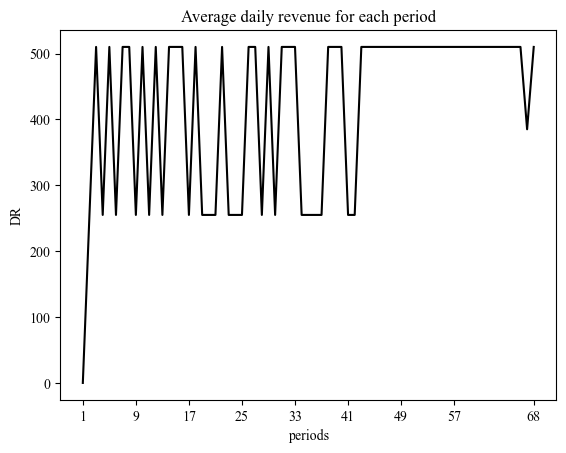

In [28]:
ax=plt.axes()
# 绘制折线图
plt.plot(day, DR,color='#000000')

ax.set_xticks([0,8,16,24,32,40,48,56,68])
ax.set_xticklabels(['1','9','17','25','33','41','49','57','68'])

# 添加标题和坐标轴标签
plt.title('Average daily revenue for each period')
plt.xlabel('periods')
plt.ylabel('DR')
 
# 显示图形
plt.show()

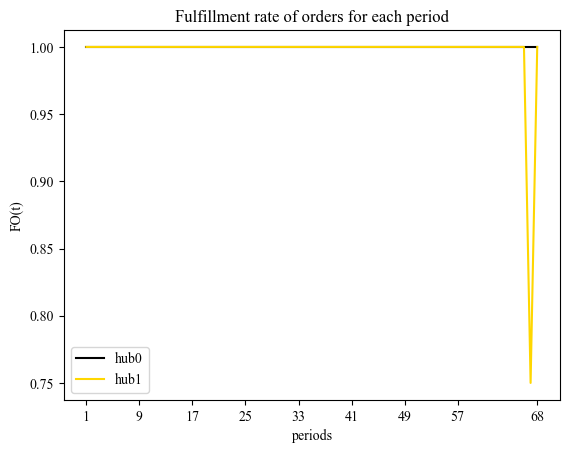

In [29]:
ax=plt.axes()
# 绘制折线图
plt.plot(day, FO[0],color='#000000',label='hub0')
plt.plot(day, FO[1],color='#FFD700',label='hub1')

ax.set_xticks([0,8,16,24,32,40,48,56,68])
ax.set_xticklabels(['1','9','17','25','33','41','49','57','68'])

# 添加标题和坐标轴标签
plt.title('Fulfillment rate of orders for each period')
plt.xlabel('periods')
plt.ylabel('FO(t)')
 
# 显示图形
plt.legend()
plt.show()

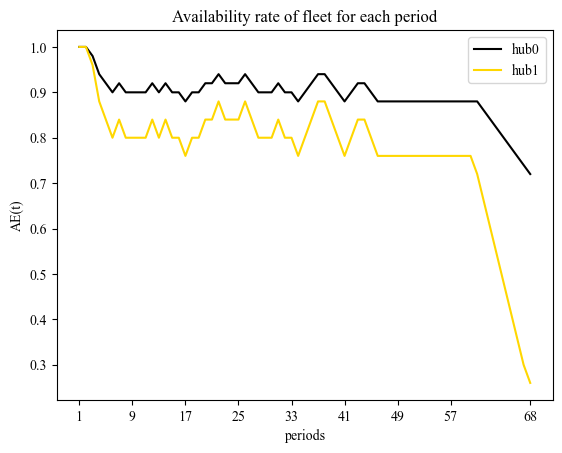

In [30]:
ax=plt.axes()
# 绘制折线图
plt.plot(day, AE[0],color='#000000',label='hub0')
plt.plot(day, AE[1],color='#FFD700',label='hub1')

ax.set_xticks([0,8,16,24,32,40,48,56,68])
ax.set_xticklabels(['1','9','17','25','33','41','49','57','68'])

# 添加标题和坐标轴标签
plt.title('Availability rate of fleet for each period')
plt.xlabel('periods')
plt.ylabel('AE(t)')
 
# 显示图形
plt.legend()
plt.show()

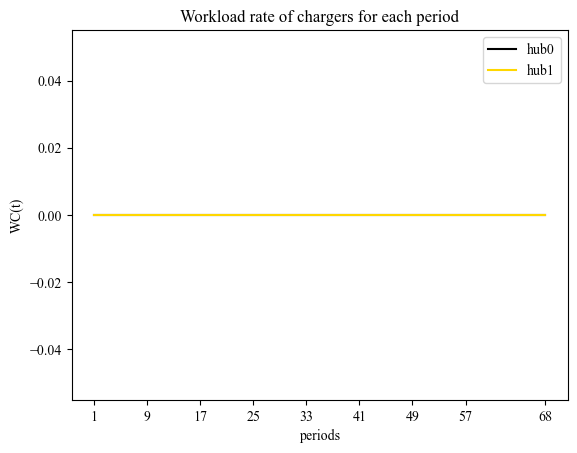

In [31]:
ax=plt.axes()
# 绘制折线图
plt.plot(day, WC[0],color='#000000',label='hub0')
plt.plot(day, WC[1],color='#FFD700',label='hub1')

ax.set_xticks([0,8,16,24,32,40,48,56,68])
ax.set_xticklabels(['1','9','17','25','33','41','49','57','68'])

# 添加标题和坐标轴标签
plt.title('Workload rate of chargers for each period')
plt.xlabel('periods')
plt.ylabel('WC(t)')
 
# 显示图形
plt.legend()
plt.show()